##            CPE-646 Pattern Recognition and Classification Project

## Dog Breed Classification using Convolutional Neural Networks

### Introduction

In this project we aim to classify the dog's breed. Code will accept any image given by the user as input and it will predict the dog's breed.

### Import the Datasets

Dogs Images --> [dogs dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip)<br>

In [1]:
# Import the relevant libraries
import numpy as np
from glob import glob

# load the data
dog_files = np.array(glob("Dog_images/dogImages/*/*/*"))

# Print the number of images in the dataset
print('There are %d total dog images.' % len(dog_files))

There are 8351 total dog images.


## Detect Dogs

In this section, we use a pre-trained model to detect dogs in images.<br>  
 
Obtain Pre-trained VGG-16 Model:<br>

The code cell below downloads the VGG-16 model, along with weights that have been trained on ImageNet, a very large, very popular dataset used for image classification and other vision tasks. 

In [2]:
import torch
import torchvision.models as models

# Define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# Check if CUDA is available
use_cuda = torch.cuda.is_available()

# Move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In the below code cell, we will write a function that accepts a path to an image (such as `'Dog_images/dogImagestrain/071.German_shepherd_dog/German_shepherd_dog_04885'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

In [3]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms

# Use pre-trained VGG-16 model to obtain index corresponding to predicted ImageNet class for image at specified path
def predict_model(model, image_path):
     
    # Load and pre-process an image from the given image_path and return the *index* of the predicted class for that image
    model.eval()
    transform = transforms.Compose([
                                    transforms.Resize(224), 
                                    transforms.CenterCrop(224), 
                                   transforms.ToTensor()])
    # image_path: path to an image
    image = Image.open(image_path)
    image = transform(image).float()
    image = image.unsqueeze(0)
    
    if use_cuda:
        image = image.cuda()
        
    predictions = model(image)
    _, index = predictions.max(1)
    
    # Predicted class index
    return index.item() 

### Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

The `dog_detector` function returns `True` if a dog is detected in an image (and `False` if not).

In [4]:
# Returns "True" if a dog is detected in the image stored at image_path(and False if not)
def dog_detector(model, image_path):
    index = predict_model(model, image_path)
    return index >= 151 and index<=268

In [5]:
from tqdm import tqdm
dog_files_short = dog_files[:100]

# Test the performance of the dog_detector function on the images in dog_files_short.
print(str(np.sum([dog_detector(VGG16, file) for file in tqdm(dog_files_short)])) + '% of dog images with a detected dog')

100%|██████████| 100/100 [00:50<00:00,  2.82it/s]


94% of dog images with a detected dog


### Improving the Dog Detector
As VGG-16 has "only" detected 94% of our dogs, I decided to try __with [DenseNet-161](https://arxiv.org/pdf/1608.06993.pdf)__, because it reports better results on the pretrained ImageNet. And indeed, __I can achieve 95% detection on the first 100 dogs__.

In [6]:
# Define densenet161 model
densenet161 = models.densenet161(pretrained=True)

# Move model to GPU if CUDA is available
if use_cuda:
    densenet161 = densenet161.cuda()

print(str(np.sum([dog_detector(densenet161, file) for file in tqdm(dog_files_short)])) + '% of dog images with a detected dog')

100%|██████████| 100/100 [00:49<00:00,  2.08it/s]


95% of dog images with a detected dog


### Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting dogs in images, we need a way to predict dog's breed from images.  In this step, we will create a CNN that classifies dog breeds.

Data loaders apply chained transformations to the loaded images. I have created two transforms:
 - One for validation and test with image resized and croped to 224x224, and then normalized;
 - One for training with some __data augmentation: random image rotation, random resized crop and random horizontal flip__

In [7]:
import os
from torchvision import datasets

# Number of subprocesses to use for data loading
num_workers = 0
# How many samples per batch to load
batch_size = 20

transform = transforms.Compose([transforms.RandomRotation(10),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

#Specify a simpler transform for validation and test
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
data_dir = 'Dog_images/dogImages'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

train_data = datasets.ImageFolder(train_dir, transform=transform)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=True)

loaders_scratch = {'train' : train_loader, 'valid': valid_loader, 'test': test_loader}

### Model Architecture

In [26]:
import torch.nn as nn
import torch.nn.functional as F

# Numner of breeds in the given dataset is 133
n_dog_breed_classes = 133

# Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 16*224*224
        self.pool = nn.MaxPool2d(2, 2) # 16*112*112
        self.batchnorm1 = nn.BatchNorm2d(16) 
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 32*112*112
        # Same MaxPool2d => 32*56*56
        self.batchnorm2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # 64*56*56
        # Same MaxPool2d => 64*28*28
        self.batchnorm3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1) # 128*28*28
        # Same MaxPool2d => 128*14*14
        self.batchnorm4 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1) # 256*14*14
        # Same MaxPool2d => 256*7*7
        self.batchnorm5 = nn.BatchNorm2d(256)
                
        self.dropout = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(256*7*7, 1024)        
        self.batchnorm_fc1 = nn.BatchNorm1d(1024)
        
        self.fc2 = nn.Linear(1024, n_dog_breed_classes)
    
    def forward(self, x):
        # Define forward behavior
        # First Convolutional Layer with ReLU activation, then MaxPool2d to reduce dimension by 2, then batch normalization to speed up learning in hidden layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batchnorm1(x)
        
        # Second Convolutional Layer with same architecture... up to Five
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batchnorm2(x)
        
        x = self.pool(F.relu(self.conv3(x)))
        x = self.batchnorm3(x)
        
        x = self.pool(F.relu(self.conv4(x)))
        x = self.batchnorm4(x)
        
        x = self.pool(F.relu(self.conv5(x)))
        x = self.batchnorm5(x)
        
        #Flatten for Fully Connected layers
        x = self.dropout(x.view(-1, 256*7*7))
        
        #First Fully Connected network
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.batchnorm_fc1(x)
        
        #Second Fully Connected Network
        x = self.fc2(x)
        return x

# Instantiate the CNN
model_scratch = Net()
print(model_scratch)

# Move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=Fals

### Model Approach:

Initially started with 3 convolutional layers and __2 fully connected layers__. The kernel size is fixed at 3x3 and padding at 1, because it's a common configuration and it has the benefits of keeping the same width and height.
Each hidden layer has a __ReLU activation__ function. It has proven its benefits over sigmoid on deep networks in hidden layers. 
After each convolutional layer, I reduced the dimensions by 2 (height and width) with a __max pooling layer__.

Before the fully connected layers, we need to flatten our tensor from 3D to 2D. There's a __dropout layer__ applied to this result to help avoid overfitting to the training data.

Then comes the first fully connected layer with 1024 neurons, with ReLU activation and dropout. 1024 was intermediate size between the output of the flatten tensor and the output layer that must have 133 neurons because we are classifying 133 dog breeds.

During the first training, the model was learning, but slowly and reached 11% of accuracy after 30-40 epochs.

I then tried to add a fourth convolutional layer, and reached higher score after 6-10 epochs.
And then my final architecture has __5 convolutional layers__ because I still got better results with a fifth convolutional layer.

I also tried to add a third, or even keep a single fully connected layer but it did not train very well.

I finally found that adding __batch normalization__ after each layer speed up training and have better results with less epochs!
The final score gives me a __22% accuracy on the test set, after 15 epochs__. I could have trained it longer and reached better results as the validation loss is still decreasing after 15 epochs.

### Loss Function and Optimizer

In [9]:
import torch.optim as optim

# loss function
criterion_scratch = nn.CrossEntropyLoss()

# Optimizer
optimizer_scratch = optim.Adagrad(model_scratch.parameters(), lr=0.01)

### Train and Validate the Model

Train and Validate the model and save the final model parameters at filepath `'model_scratch.pt'`.

In [10]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # Initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        # Train the model
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # Move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # Find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)            
            loss.backward()
            optimizer.step()
            
            ## Record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        # Validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # Move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # Update the average validation loss
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # Print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # Return the trained model
    return model

In [11]:
# Train the model
numober_of_epochs = 15
model_scratch = train(numober_of_epochs, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 5.031742 	Validation Loss: 4.453683
Validation loss decreased (inf --> 4.453683).  Saving model ...
Epoch: 2 	Training Loss: 4.565035 	Validation Loss: 4.212690
Validation loss decreased (4.453683 --> 4.212690).  Saving model ...
Epoch: 3 	Training Loss: 4.342662 	Validation Loss: 3.992608
Validation loss decreased (4.212690 --> 3.992608).  Saving model ...
Epoch: 4 	Training Loss: 4.168014 	Validation Loss: 3.974394
Validation loss decreased (3.992608 --> 3.974394).  Saving model ...
Epoch: 5 	Training Loss: 4.054108 	Validation Loss: 3.762792
Validation loss decreased (3.974394 --> 3.762792).  Saving model ...
Epoch: 6 	Training Loss: 3.906999 	Validation Loss: 3.644994
Validation loss decreased (3.762792 --> 3.644994).  Saving model ...
Epoch: 7 	Training Loss: 3.838516 	Validation Loss: 3.645457
Epoch: 8 	Training Loss: 3.774010 	Validation Loss: 3.583539
Validation loss decreased (3.644994 --> 3.583539).  Saving model ...
Epoch: 9 	Training Loss: 3.659138 

In [12]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

<All keys matched successfully>

### Test the Model

In [13]:
def test(loaders, model, criterion, use_cuda):

    # Monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # Move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Calculate the loss
        loss = criterion(output, target)
        # Update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # Convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # Compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [14]:
# Call the test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.123541


Test Accuracy: 22% (192/836)


__22% of accuracy is much higher than the 10% expected for this task__. So I'll now move to Transfer Learning and see how accuracy can be improved.

### Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images. CNN must attain at least 60% accuracy on the test set.

In [15]:
# Specify data loaders
loaders_transfer = loaders_scratch

### Model Architecture

Used transfer learning to create a CNN to classify dog breed.

In [16]:
import torchvision.models as models
import torch.nn as nn

# model_transfer = models.vgg16(pretrained=True)
model_transfer = models.densenet161(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
n_inputs = model_transfer.classifier.in_features

# New layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, n_dog_breed_classes)

# Model_transfer.classifier[6] = last_layer
model_transfer.classifier = last_layer

if use_cuda:
    model_transfer = model_transfer.cuda()

### Model Approach:

I first tried to reuse __VGG-16__ because it's a __pretrained model__ that achieved great results in ImageNet, without having too many layers.  
The model is already trained to detect dogs, and __already classified a lot of dog breeds__. So it can detect the features we need for our problem.  

We just need two modifications:
 - Change the model so that it does not train these features anymore: requires_grad=False
 - And then __replace the last fully connected layer (the classifier itself) so that it outputs 133 classes__ instead of 1000.

I achieved great results from the very first epoch and quickly reached 75-80% of accuracy after 5 epochs.

Later I selected __[DenseNet-161](https://arxiv.org/pdf/1608.06993.pdf)__ as a good model to try because it has __improved performance over VGG-16 on ImageNet__ and it introduces an interesting architecture with __each layer taking all preceding feature-maps as input__. Moreover despite it has more layers than VGG-16, the time to train a single epoch is very similar.

### Loss Function and Optimizer

In [17]:
# Loss Function
criterion_transfer = nn.CrossEntropyLoss()

# Optimizer
optimizer_transfer = optim.Adagrad(model_transfer.classifier.parameters(), lr=0.01)

### Train and Validate the Model

Train and Validate the model and save the final model parameters at filepath `'model_scratch.pt'`.

In [18]:
# Train the model
numober_of_epochs=10
model_transfer = train(numober_of_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 2.254641 	Validation Loss: 0.828822
Validation loss decreased (inf --> 0.828822).  Saving model ...
Epoch: 2 	Training Loss: 1.108967 	Validation Loss: 0.574439
Validation loss decreased (0.828822 --> 0.574439).  Saving model ...
Epoch: 3 	Training Loss: 0.907869 	Validation Loss: 0.505842
Validation loss decreased (0.574439 --> 0.505842).  Saving model ...
Epoch: 4 	Training Loss: 0.832990 	Validation Loss: 0.455507
Validation loss decreased (0.505842 --> 0.455507).  Saving model ...
Epoch: 5 	Training Loss: 0.771913 	Validation Loss: 0.436093
Validation loss decreased (0.455507 --> 0.436093).  Saving model ...
Epoch: 6 	Training Loss: 0.731356 	Validation Loss: 0.407032
Validation loss decreased (0.436093 --> 0.407032).  Saving model ...
Epoch: 7 	Training Loss: 0.710914 	Validation Loss: 0.388167
Validation loss decreased (0.407032 --> 0.388167).  Saving model ...
Epoch: 8 	Training Loss: 0.679870 	Validation Loss: 0.379401
Validation loss decreased (0.38816

### Test the Model

In [19]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.399370


Test Accuracy: 87% (733/836)


### Predict Dog Breed with the Model

The function takes an image path as input and returns the dog breed (Affenpinscher, Afghan hound, etc) that is predicted by the model.

In [20]:
data_transfer = {'train' : train_data, 'valid': valid_data, 'test': test_data}

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_dog_breed(image_path):
    # load the image and return the predicted breed
    
    model_transfer.eval()
    transform = transforms.Compose([
                                    transforms.Resize(224), 
                                    transforms.CenterCrop(224), 
                                    transforms.ToTensor()])
    image = Image.open(image_path)
    image = transform(image).float()
    image = image.unsqueeze(0)
    
    if use_cuda:
        image = image.cuda()
        
    predictions = model_transfer(image)
    _, index = predictions.max(1)
    
    return class_names[index.item()]

In [32]:
import cv2 
import matplotlib.pyplot as plt                        
%matplotlib inline  

# Function to display the breed of the dog
def display_image(image_path):
    image = cv2.imread(image_path)
    cv_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)  
    plt.show()  

def run_model(image_path):
    # Handle cases for a human face, dog, and neither
    display_image(image_path)
    if dog_detector(densenet161, image_path):
        print('Hello dog')
        print('I predict you are a ' + predict_dog_breed(image_path))
    else:
        print('I cannot see any dog here!!!')
    print('________________________________________________________________________')

### Testing the Algorithm

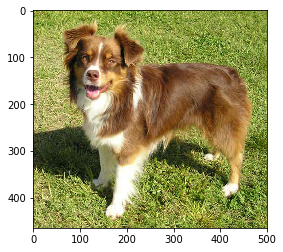

Hello dog
I predict you are a Nova scotia duck tolling retriever
________________________________________________________________________


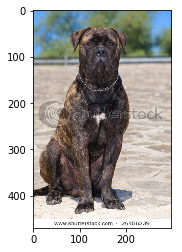

Hello dog
I predict you are a Cane corso
________________________________________________________________________


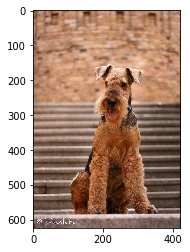

Hello dog
I predict you are a Airedale terrier
________________________________________________________________________


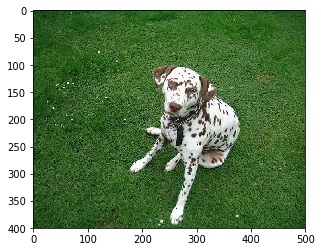

Hello dog
I predict you are a Dalmatian
________________________________________________________________________


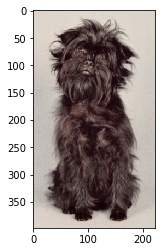

Hello dog
I predict you are a Affenpinscher
________________________________________________________________________


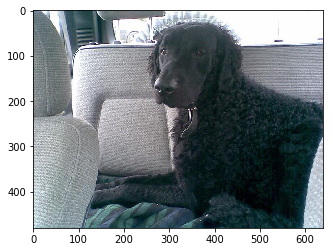

Hello dog
I predict you are a Curly-coated retriever
________________________________________________________________________


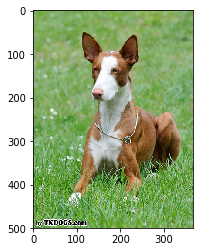

Hello dog
I predict you are a Ibizan hound
________________________________________________________________________


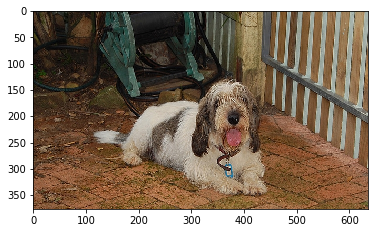

Hello dog
I predict you are a Petit basset griffon vendeen
________________________________________________________________________


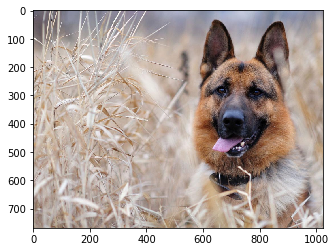

Hello dog
I predict you are a German shepherd dog
________________________________________________________________________


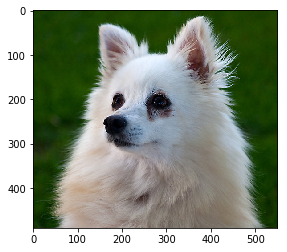

Hello dog
I predict you are a American eskimo dog
________________________________________________________________________


In [43]:
run_model(dog_files[88])
run_model(dog_files[300])
run_model(dog_files[1000])
run_model(dog_files[409])
run_model(dog_files[876])
run_model(dog_files[7896])
run_model(dog_files[5362])
run_model(dog_files[6999])
run_model(dog_files[8002])
run_model(dog_files[40])

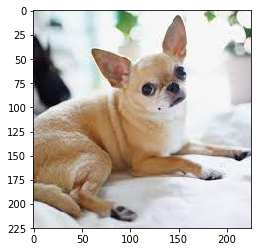

Hello dog
I predict you are a Chihuahua
________________________________________________________________________


In [47]:
run_model('Output_images/chihuahua.jpg')

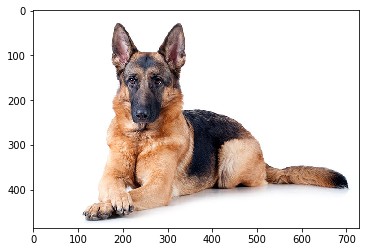

Hello dog
I predict you are a German shepherd dog
________________________________________________________________________


In [44]:
run_model('Output_images/German-Shepherd.jpg')

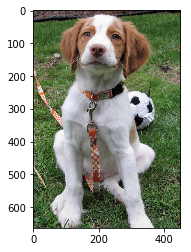

Hello dog
I predict you are a Brittany
________________________________________________________________________


In [37]:
run_model('Output_images/Brittany.jpg')

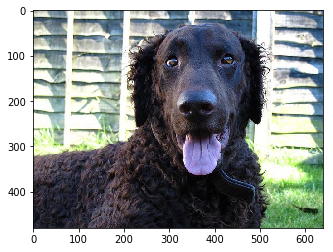

Hello dog
I predict you are a Curly-coated retriever
________________________________________________________________________


In [38]:
run_model('Output_images/Curly-coated_retriever.jpg')

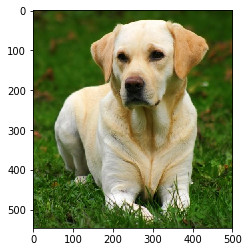

Hello dog
I predict you are a Labrador retriever
________________________________________________________________________


In [39]:
run_model('Output_images/Labrador_retriever.jpg')

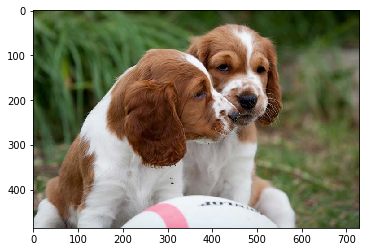

Hello dog
I predict you are a Welsh springer spaniel
________________________________________________________________________


In [45]:
run_model('Output_images/Welsh-Springer-Spaniel.jpg')

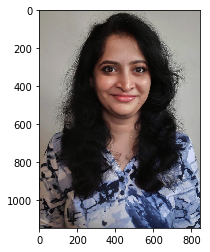

I cannot see any dog here!!!
________________________________________________________________________


In [41]:
run_model('Output_images/Sneha.jpg')